# Market Data Simulation Demo

Generate irregular time series with simulated prices and activity bursts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import pandas as pd

plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.figsize'] = (15, 8)

## Generate Irregular Time Series

In [15]:
# Simulation parameters
total_duration = 36000  # 1 hour in seconds
base_frequency = 2.0   # Average 2 ticks per second
burst_probability = 0.02  # 2% chance of burst per second
burst_intensity = 20   # 20x normal frequency during bursts
burst_duration = 3.0   # Bursts last 3 seconds

np.random.seed(42)

# Generate irregular timestamps
timestamps = []
current_time = 0.0

while current_time < total_duration:
    # Check for burst
    if np.random.random() < burst_probability:
        # Burst period - high frequency
        burst_end = current_time + burst_duration
        while current_time < burst_end and current_time < total_duration:
            # Much shorter intervals during burst
            interval = np.random.exponential(1.0 / (base_frequency * burst_intensity))
            current_time += interval
            timestamps.append(current_time)
    else:
        # Normal period
        interval = np.random.exponential(1.0 / base_frequency)
        current_time += interval
        timestamps.append(current_time)

timestamps = np.array(timestamps)
timestamps = timestamps[timestamps <= total_duration]  # Remove any overflow

print(f"Generated {len(timestamps)} ticks over {total_duration/60:.1f} minutes")
print(f"Average frequency: {len(timestamps)/total_duration:.2f} ticks/second")

Generated 223754 ticks over 600.0 minutes
Average frequency: 6.22 ticks/second


## Generate Price Series

In [16]:
# Price simulation parameters
initial_price = 100.0

# Generate simple price movements
prices = np.zeros(len(timestamps))
prices[0] = initial_price

for i in range(1, len(timestamps)):
    # Simple random walk: small random steps
    random_step = np.random.normal(0, 0.05)  # ±5 cents average
    
    # Add tiny periodic pattern
    time_hours = timestamps[i] / 3600  # Convert to hours
    daily_drift = 0.01 * np.sin(2 * np.pi * time_hours / 24)  # 1 cent daily pattern
    
    # Update price with small absolute changes
    prices[i] = prices[i-1] + random_step + daily_drift

print(f"Price range: ${prices.min():.2f} to ${prices.max():.2f}")
print(f"Final price: ${prices[-1]:.2f} (change: {(prices[-1]/initial_price-1)*100:+.2f}%)")
print(f"Price std dev: ${np.std(prices):.2f}")

Price range: $99.81 to $1681.86
Final price: $1681.86 (change: +1581.86%)
Price std dev: $525.86


## Calculate Tick Density

In [17]:
# Calculate number of ticks in the last second for each timestamp
window_size = 1.0  # 1 second window
tick_density = np.zeros(len(timestamps))

for i, t in enumerate(timestamps):
    # Count ticks in the window [t-window_size, t]
    window_start = t - window_size
    ticks_in_window = np.sum((timestamps >= window_start) & (timestamps <= t))
    tick_density[i] = ticks_in_window

print(f"Tick density range: {tick_density.min():.0f} to {tick_density.max():.0f} ticks/second")
print(f"Average tick density: {tick_density.mean():.2f} ticks/second")

# Find burst periods (high tick density)
burst_threshold = tick_density.mean() + 2 * tick_density.std()
burst_indices = np.where(tick_density > burst_threshold)[0]
print(f"Burst threshold: {burst_threshold:.1f} ticks/second")
print(f"Number of burst ticks: {len(burst_indices)} ({len(burst_indices)/len(timestamps)*100:.1f}%)")

Tick density range: 1 to 71 ticks/second
Average tick density: 26.22 ticks/second
Burst threshold: 61.4 ticks/second
Number of burst ticks: 176 (0.1%)


## Plot Price and Activity

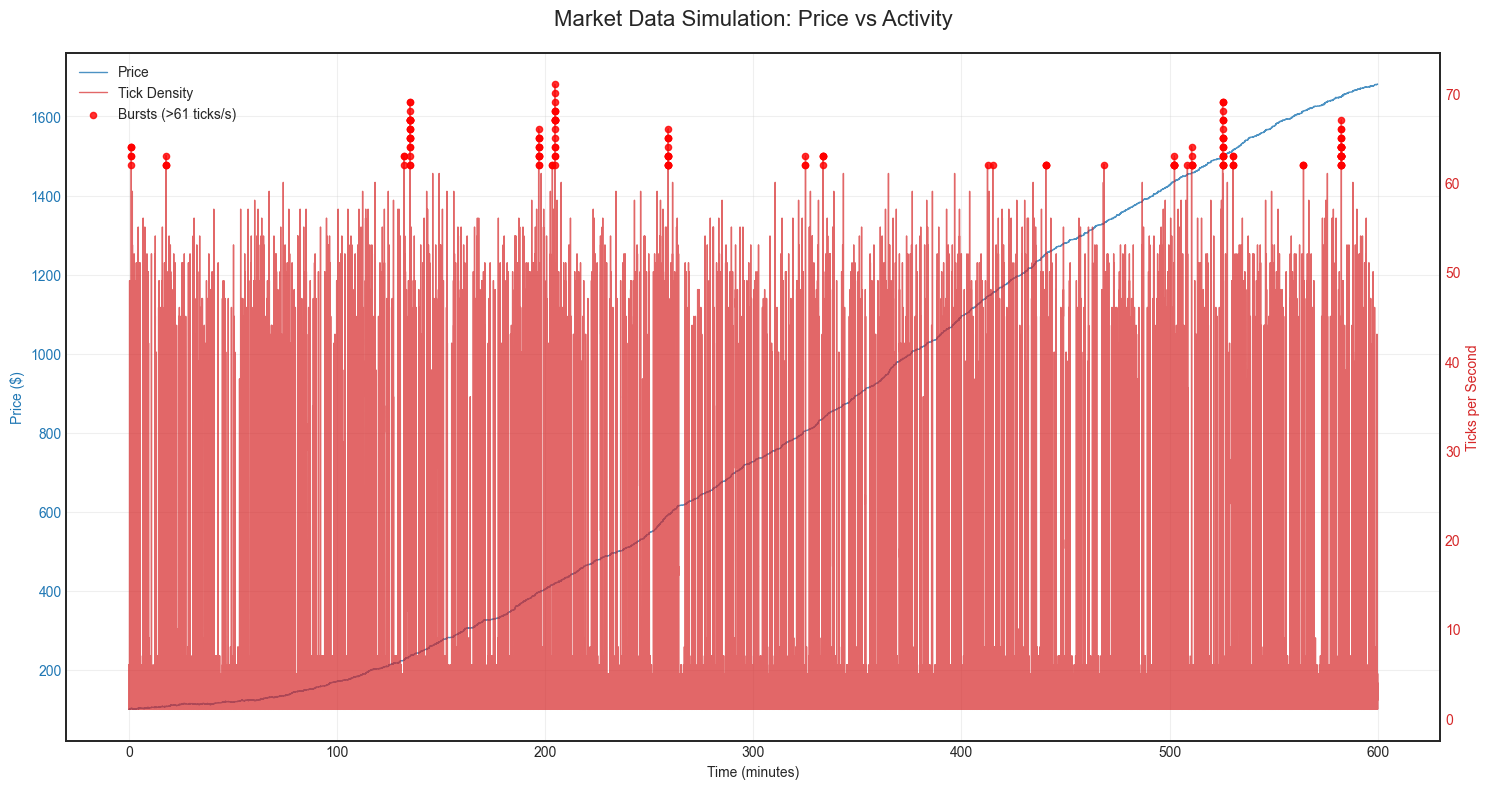


📊 Summary Statistics:
   Total duration: 600.0 minutes
   Total ticks: 223,754
   Price volatility: 0.019%
   Max tick burst: 71 ticks/second
   Time of max activity: 204.7 minutes


In [18]:
# Create the dual y-axis plot
fig, ax1 = plt.subplots(figsize=(15, 8))

# Convert timestamps to minutes for better readability
time_minutes = timestamps / 60

# Plot price on left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Price ($)', color=color1)
line1 = ax1.plot(time_minutes, prices, color=color1, linewidth=1, alpha=0.8, label='Price')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for tick density
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Ticks per Second', color=color2)
line2 = ax2.plot(time_minutes, tick_density, color=color2, linewidth=1, alpha=0.7, label='Tick Density')
ax2.tick_params(axis='y', labelcolor=color2)

# Highlight burst periods
if len(burst_indices) > 0:
    burst_times = time_minutes[burst_indices]
    burst_densities = tick_density[burst_indices]
    ax2.scatter(burst_times, burst_densities, color='red', s=20, alpha=0.8,
               label=f'Bursts (>{burst_threshold:.0f} ticks/s)', zorder=5)

# Add title and legends
plt.title('Market Data Simulation: Price vs Activity', fontsize=16, pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 Summary Statistics:")
print(f"   Total duration: {total_duration/60:.1f} minutes")
print(f"   Total ticks: {len(timestamps):,}")
print(f"   Price volatility: {np.std(np.diff(np.log(prices)))*100:.3f}%")
print(f"   Max tick burst: {tick_density.max():.0f} ticks/second")
print(f"   Time of max activity: {time_minutes[np.argmax(tick_density)]:.1f} minutes")

## Neural Network Population

In [19]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

from numba_ga import (
    initialize_population,
    predict_population, 
    reset_population_memory
)

# Create neural network population
pop_size = 50
layer_sizes = np.array([1, 80,20, 3], dtype=np.int64)  # 1 input → 8 hidden → 3 outputs
activations = np.array([1 ,1,0], dtype=np.int64)     # ReLU → Linear

# Initialize population
population = initialize_population(pop_size, layer_sizes, seed=123)
pop_states, pop_times = reset_population_memory(layer_sizes, pop_size)

print(f"🧠 Neural Network Population:")
print(f"   Population size: {pop_size}")
print(f"   Architecture: {list(layer_sizes)}")
print(f"   Parameters per individual: {population.shape[1]}")
print(f"   Total parameters: {pop_size * population.shape[1]:,}")

print(f"\\n📊 Market Data:")
print(f"   Total ticks: {len(timestamps)}")
print(f"   Time range: {timestamps[0]:.1f}s to {timestamps[-1]:.1f}s")

🧠 Neural Network Population:
   Population size: 50
   Architecture: [np.int64(1), np.int64(80), np.int64(20), np.int64(3)]
   Parameters per individual: 1946
   Total parameters: 97,300
\n📊 Market Data:
   Total ticks: 223754
   Time range: 1.5s to 35999.8s


In [20]:
# Run neural networks on ALL market data ticks
for i in range(len(timestamps)):
    # Single input: normalized price
    normalized_price = (prices[i] - 100.0) / 10.0  # Center around 0
    input_vector = np.array([normalized_price], dtype=np.float64)
    
    # Convert time to milliseconds (numba_ga expects ms)
    current_time_ms = timestamps[i] * 1000
    inputs_tuple = (current_time_ms, input_vector)
    
    # Predict for entire population
    outputs, pop_states, pop_times = predict_population(
        population, layer_sizes, activations, inputs_tuple, pop_states, pop_times
    )

# Show only the FINAL outputs after processing all ticks
final_outputs = outputs  # This is the last prediction from the loop

print(f"\\n🎯 Final Population Outputs (after processing {len(timestamps)} ticks):")
print(f"   Output shape: {final_outputs.shape}")
print(f"   Processing complete!")

print(f"\\n📈 Final Outputs by Individual:")
for i in range(min(10, pop_size)):  # Show first 10 individuals
    print(f"   Individual {i+1:2d}: [{final_outputs[i, 0]:7.3f}, {final_outputs[i, 1]:7.3f}, {final_outputs[i, 2]:7.3f}]")

# Population statistics for final outputs
print(f"\\n📊 Final Output Statistics:")
for output_idx in range(3):
    output_vals = final_outputs[:, output_idx]
    print(f"   Output {output_idx+1}: min={output_vals.min():7.3f}, max={output_vals.max():7.3f}, mean={output_vals.mean():7.3f}")

print(f"\\n✅ All {len(timestamps)} market ticks processed with temporal memory!")

\n🎯 Final Population Outputs (after processing 223754 ticks):
   Output shape: (50, 3)
   Processing complete!
\n📈 Final Outputs by Individual:
   Individual  1: [ -6.883, -20.851,  18.015]
   Individual  2: [ 79.786,  78.596,  19.050]
   Individual  3: [-70.434, -44.755, -98.074]
   Individual  4: [-89.533,  13.182, -145.024]
   Individual  5: [ -8.762, -14.012,  37.875]
   Individual  6: [-92.952,  18.930, -20.360]
   Individual  7: [-115.392,  31.766, 151.866]
   Individual  8: [-24.918,  65.680,   1.743]
   Individual  9: [-46.464,  20.673,  -6.292]
   Individual 10: [-13.404,  29.468,  38.532]
\n📊 Final Output Statistics:
   Output 1: min=-170.888, max=131.796, mean=-17.011
   Output 2: min=-188.685, max=129.874, mean= -1.195
   Output 3: min=-201.809, max=151.866, mean=-13.879
\n✅ All 223754 market ticks processed with temporal memory!


In [21]:
output_vals

array([  18.01520222,   19.05020901,  -98.0741187 , -145.02432269,
         37.87454576,  -20.35964079,  151.86628192,    1.74338628,
         -6.29218549,   38.53176558,   26.62648552,  -17.17417324,
        -51.61687478,   -8.89604649, -137.86465889,  -58.36387286,
        -37.79627039,   16.96153258,   -8.40817251,  -29.6020919 ,
       -201.80929458,  -70.05924639,  -26.08023763,  -16.04402571,
        136.15405771,   24.57214478,   10.40947078,  -45.42882552,
        -22.00009591,   11.32144438,  -73.50146453,    6.35869349,
         33.65032318,  -33.00551464,  -75.02962367,   -2.66225271,
        -39.11029295,  -18.43097864,   -6.99258302,   -4.20807434,
         -3.69504703,   17.40008355,   -6.63573096,  -23.7880638 ,
         48.05227851,   40.50959609,   17.32271379,  -36.89363723,
         65.20361322,  -90.72934076])

In [22]:
final_outputs

array([[-6.88339605e+00, -2.08511502e+01,  1.80152022e+01],
       [ 7.97856508e+01,  7.85955916e+01,  1.90502090e+01],
       [-7.04341922e+01, -4.47549971e+01, -9.80741187e+01],
       [-8.95326595e+01,  1.31819350e+01, -1.45024323e+02],
       [-8.76155813e+00, -1.40119443e+01,  3.78745458e+01],
       [-9.29523873e+01,  1.89300397e+01, -2.03596408e+01],
       [-1.15391558e+02,  3.17659847e+01,  1.51866282e+02],
       [-2.49177712e+01,  6.56804659e+01,  1.74338628e+00],
       [-4.64643359e+01,  2.06725921e+01, -6.29218549e+00],
       [-1.34044728e+01,  2.94681296e+01,  3.85317656e+01],
       [ 7.38786971e+00, -1.14361740e+01,  2.66264855e+01],
       [ 5.60808887e+01, -1.20357811e+02, -1.71741732e+01],
       [-3.72150112e+01,  9.65789887e+01, -5.16168748e+01],
       [ 1.05118520e+01, -1.03372104e+01, -8.89604649e+00],
       [-7.48550156e+01, -1.48680961e+02, -1.37864659e+02],
       [-2.07603069e+01, -3.55631804e+01, -5.83638729e+01],
       [-9.78223403e+00,  9.49669946e+00